<h1 style="font-size:2.5rem;color:purple;">Artificial Intelligence II</h1>
<h1 style="font-size:1.5rem;color:purple;">Deep Learning for Natural Language Processing (NLP)</h1>

In this assignment, we develop a sentiment classifier using only **Logistic Regression** and only **TF-IDF** in Python on a given Twitter dataset.  
The dataset consists of three files: *train_dataset.csv, val_dataset.csv, test_dataset.csv*.  
Train and Val consists of three columns: **ID, Text, Label**, and Test consists of two columns: **ID, Text**.

In [398]:
# Import libraries

import pandas as pd

import warnings

import re

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter

import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve

In [399]:
# Ingore warnings
warnings.filterwarnings("ignore")

In [400]:
np.random.seed(42)

First we load the given data (*test.csv* to use for training the model, *val.csv* to use for validation of training and *test.csv* to use for predictions)

In [401]:
# Read train dataset (to use for training)
df_train = pd.read_csv('datasets/train_dataset.csv')

# Read val dataset (to use for validation of training)
df_val = pd.read_csv('datasets/val_dataset.csv')

# Read test dataset (to use for predictions)
df_test = pd.read_csv('datasets/test_dataset.csv')

Let's take a look at the train dataset (the other two datasets have a similar structure to this one)

In [402]:
df_train

,ID,Text,Label
0,189385,@whoisralphie dude I'm so bummed ur leaving!,0
1,58036,"oh my god, a severed foot was foun in a wheely...",0
2,190139,I end up &quot;dog dialing&quot; sumtimes. Wha...,1
3,99313,@_rachelx meeeee toooooo!,0
4,157825,"I was hoping I could stay home and work today,...",0
...,...,...,...
148383,99894,just love the jonas brothers its tooo bad i w...,0
148384,61015,another day gone by....time is moving so fast...,0
148385,36598,"fuck college, i'm just gonna marry rich. : fuc...",1
148386,83799,ZOMGZ NEW SONG FTW. remember that night. &lt;3,1


<h1 style="font-size:1.5rem;color:purple;">Data Preprocessing</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we clean the datasets.</h1>

First remove duplicate values, then remove unwanted symbols/characters (e.g. URLs, @mentions, numbers/characters) and convert every letter to lowercase.

In [403]:
# Drop duplicate values 
df_train = df_train.drop_duplicates().reset_index(drop=True)
df_val = df_val.drop_duplicates().reset_index(drop=True)

Function to clean a text

In [404]:
# Function to clean text

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions/usernames
    text = re.sub(r'@\w+', '', text)
    # Remove numbers and characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()

    return text


# Clean only Text column
df_train['Text'] = df_train['Text'].apply(clean_text)
df_val['Text'] = df_val['Text'].apply(clean_text)
df_test['Text'] = df_test['Text'].apply(clean_text)

Drop rows with NaN values

In [405]:
# Drop NaN values
df_train = df_train.replace(r'^\s*$', pd.NA, regex=True).dropna()
df_val = df_val.replace(r'^\s*$', pd.NA, regex=True).dropna()

Now take a look at the same dataset as above, but cleaned (the other two datasets are cleaned as well)

In [406]:
df_train

,ID,Text,Label
0,189385,dude im so bummed ur leaving,0
1,58036,oh my god a severed foot was foun in a wheely ...,0
2,190139,i end up quotdog dialingquot sumtimes whats do...,1
3,99313,meeeee toooooo,0
4,157825,i was hoping i could stay home and work today ...,0
...,...,...,...
148383,99894,just love the jonas brothers its tooo bad i w...,0
148384,61015,another day gone bytime is moving so fast,0
148385,36598,fuck college im just gonna marry rich fuck co...,1
148386,83799,zomgz new song ftw remember that night lt,1


Reduce repeated characters in 2 (e.g. meeeeee toooooo -> mee too)

Function to reduce repeated characters

In [407]:
# Function to reduce repeated characters to 2
def reduce_repeated_characters(text):
   
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # Reduce characters repeated (3 or more times) to 2
    return text

Reduce repeated characters in Text column

In [408]:
df_train['Text'] = df_train['Text'].apply(reduce_repeated_characters)
df_val['Text'] = df_val['Text'].apply(reduce_repeated_characters)
df_test['Text'] = df_test['Text'].apply(reduce_repeated_characters)

In [409]:
df_train

,ID,Text,Label
0,189385,dude im so bummed ur leaving,0
1,58036,oh my god a severed foot was foun in a wheely ...,0
2,190139,i end up quotdog dialingquot sumtimes whats do...,1
3,99313,mee too,0
4,157825,i was hoping i could stay home and work today ...,0
...,...,...,...
148383,99894,just love the jonas brothers its too bad i wi...,0
148384,61015,another day gone bytime is moving so fast,0
148385,36598,fuck college im just gonna marry rich fuck co...,1
148386,83799,zomgz new song ftw remember that night lt,1


Remove word "im" from text column, since this word is one of the most frequent words and is meaningless for model training

In [410]:
# Function to remove word "im" from text
def remove_im(text):
    return re.sub(r'\bim\b', '', text, flags=re.IGNORECASE)

In [411]:
df_train['Text'] = df_train['Text'].apply(remove_im)
df_val['Text'] = df_val['Text'].apply(remove_im)
df_test['Text'] = df_test['Text'].apply(remove_im)

<h1 style="font-size:1.5rem;color:purple;">Analysis</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we will try to visualize the data and their statistics.</h1>

Create some wordclouds to make it clear and visible which words are used more often

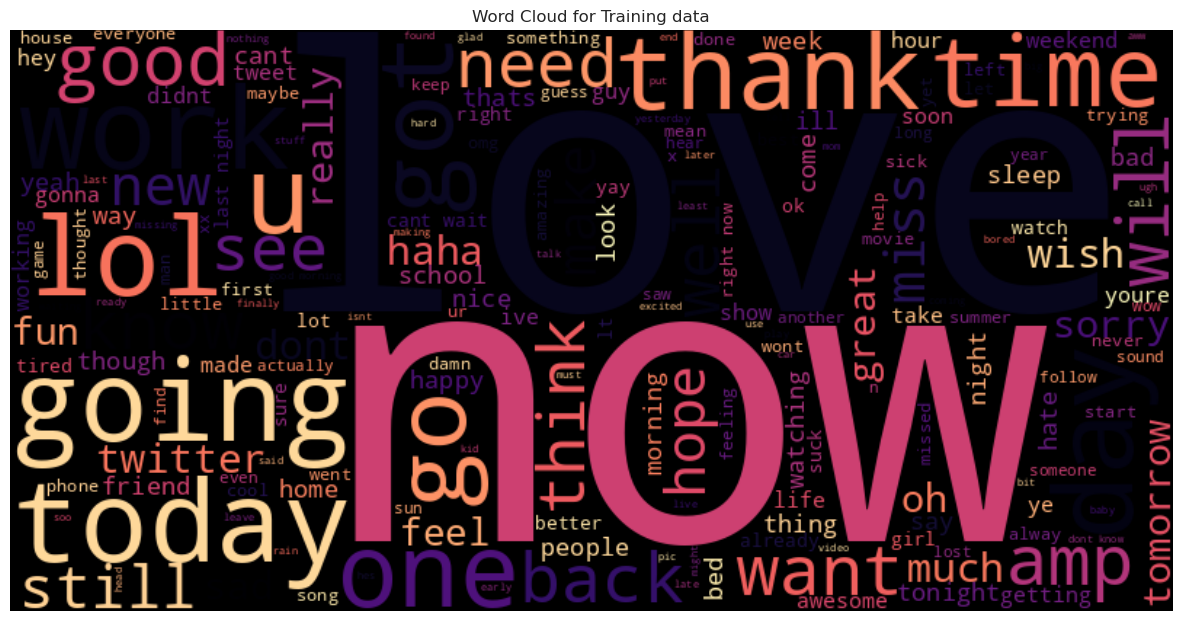

In [412]:
# Wordcloud for TRAINING DATA

# Combine all text entries into one string
text = " ".join(df_train['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Training data")
plt.axis("off")
plt.show()

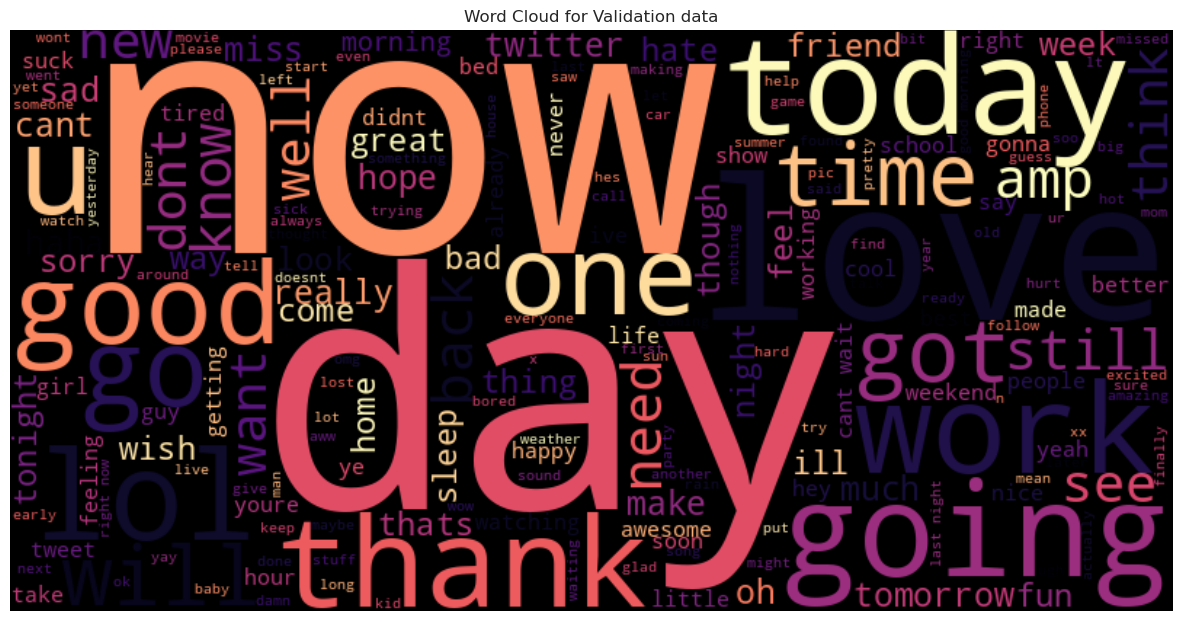

In [413]:
# Wordcloud for VALIDATION DATA

# Combine all text entries into one string
text = " ".join(df_val['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Validation data")
plt.axis("off")
plt.show()

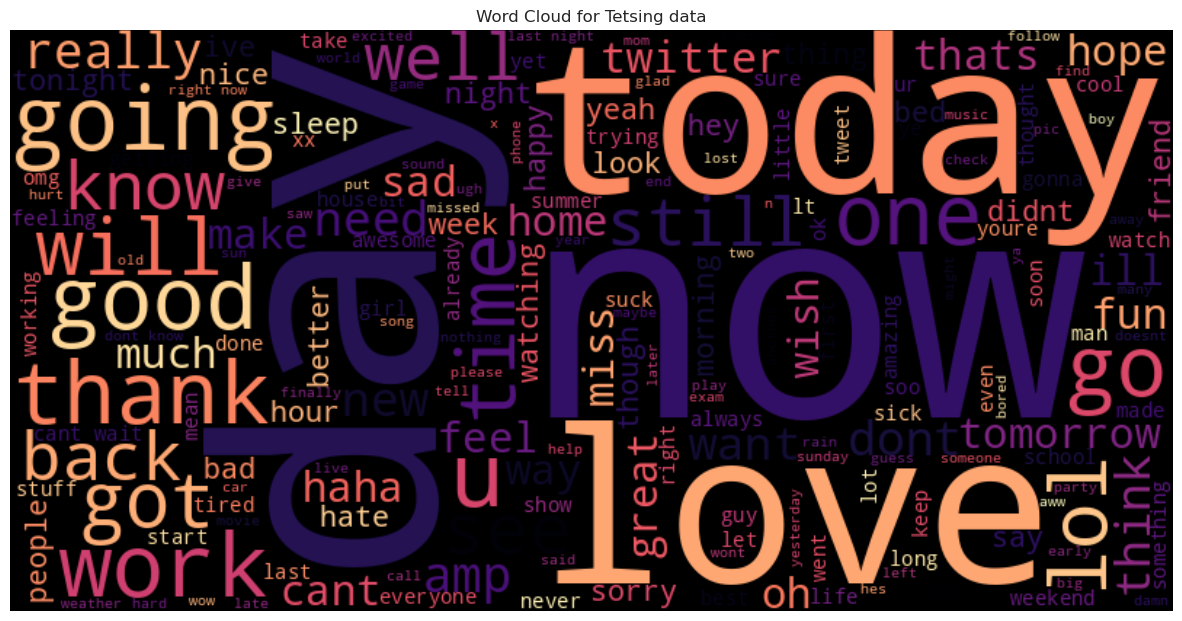

In [414]:
# Wordcloud for TESTING DATA

# Combine all text entries into one string
text = " ".join(df_test['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Tetsing data")
plt.axis("off")
plt.show()

Find and print the number of labels (1 for positive, 0 for negative) in every dataframe  
(Test dataframe doesn't have "Label" column)

In [415]:
# Count labels
label_counts = df_train["Label"].value_counts()

print("Labels in Train data:")
label_counts

Labels in Train data:


Label
0    74031
1    74019
Name: count, dtype: int64

In [416]:
# Count labels
label_counts = df_val["Label"].value_counts()

print("Labels in Validation data:")
label_counts

Labels in Validation data:


Label
0    21165
1    21152
Name: count, dtype: int64

The labels seem to be balanced, since we have about equal numbers of positives and negatives in both dataframes.

Make some plots showing the top 10 most frequent words per label

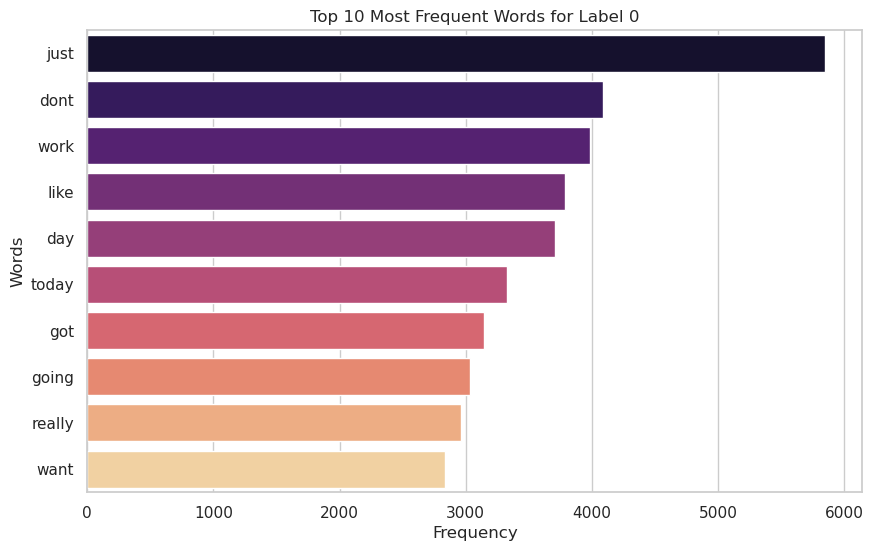

In [ ]:
# Set CountVectorizer to count frequent words
vectorizer = CountVectorizer(stop_words='english')

sns.set(style='whitegrid')

label = 0
   
text_label = df_train[df_train['Label'] == label]['Text']
    
# Train CountVectorizer for this Label
X = vectorizer.fit_transform(text_label)
    
# Count frequent words
word_counts = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()
    
# Create a Counter to find top 10 frequent words
word_freq = Counter(dict(zip(words, word_counts)))
most_common_words = word_freq.most_common(10)

# Create plot for label
plt.figure(figsize=(10, 6))
plt.title(f'Top 10 Most Frequent Words for Label {label}')
    
words, counts = zip(*most_common_words)
    
# Create bar plot
sns.barplot(x=counts, y=words, palette='magma')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()
    

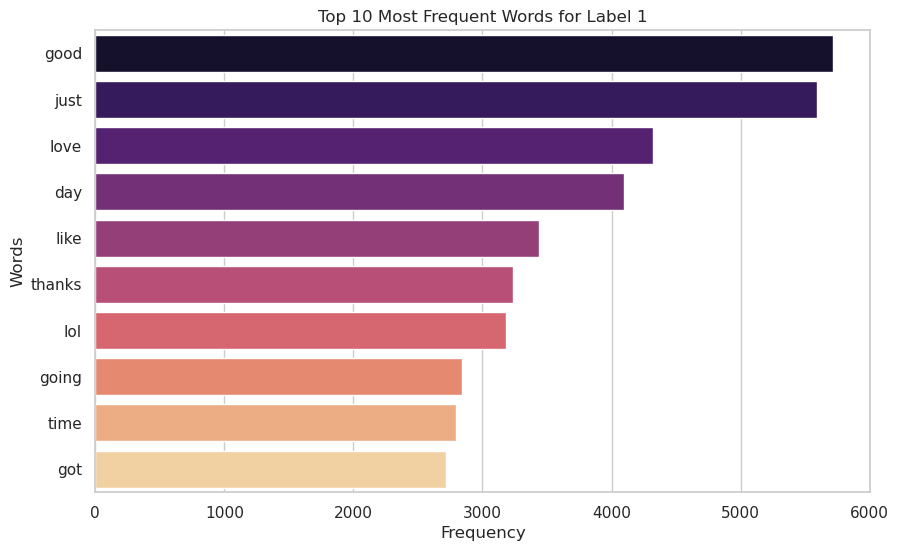

In [439]:
# Set CountVectorizer to count frequent words
vectorizer = CountVectorizer(stop_words='english')

sns.set(style='whitegrid')

label = 1
   
text_label = df_train[df_train['Label'] == label]['Text']
    
# Train CountVectorizer for this Label
X = vectorizer.fit_transform(text_label)
    
# Count frequent words
word_counts = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()
    
# Create a Counter to find top 10 frequent words
word_freq = Counter(dict(zip(words, word_counts)))
most_common_words = word_freq.most_common(10)

# Create plot for label
plt.figure(figsize=(10, 6))
plt.title(f'Top 10 Most Frequent Words for Label {label}')
    
words, counts = zip(*most_common_words)
    
# Create bar plot
sns.barplot(x=counts, y=words, palette='magma')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

<h1 style="font-size:1.5rem;color:purple;">Vectorization</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we will convert text/data into numerical form so that it can be used by machine learning models.</h1>

We use TF-IDF (Term Frequency - Inverse Document Frequency) 

In [418]:
# Create TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 2))

Convert Train set into vector

In [419]:
# Convert text into TF-IDF vector for train set
X_train = tfidf.fit_transform(df_train['Text'])

y_train = df_train['Label']

print(X_train)

  (0, 610758)	0.4191865061898493
  (0, 84610)	0.46062451100632024
  (0, 507032)	0.37017950425687407
  (0, 154686)	0.4344800408389714
  (0, 310948)	0.25429800741035924
  (0, 610459)	0.22248696507751595
  (0, 84559)	0.2941803898002402
  (0, 506827)	0.1285329361732672
  (0, 154554)	0.2628140369208068
  (1, 497520)	0.16069754054670507
  (1, 178975)	0.13597789297194776
  (1, 259812)	0.18606049749140768
  (1, 368592)	0.1183043503544494
  (1, 200630)	0.11061493602724515
  (1, 350676)	0.16874758597047235
  (1, 318797)	0.19245017801283487
  (1, 280444)	0.1706037160138185
  (1, 195603)	0.18606049749140768
  (1, 565813)	0.1780104520676404
  (1, 637917)	0.1587251081954595
  (1, 109300)	0.19245017801283487
  (1, 269357)	0.19245017801283487
  (1, 68574)	0.19245017801283487
  (1, 636899)	0.19245017801283487
  (1, 272480)	0.19245017801283487
  :	:
  (148049, 562149)	0.23466178684025793
  (148049, 150556)	0.23466178684025793
  (148049, 34691)	0.23466178684025793
  (148049, 90237)	0.23466178684025793
  

In [421]:
print(X_train.shape)

(148050, 672043)


Convert Validation set into vector

In [422]:
# Convert text into TF-IDF vector for validation set
X_val = tfidf.transform(df_val['Text'])

# Extract labels
y_val = df_val['Label']

print(X_val)

  (0, 654068)	0.23025214481259304
  (0, 654022)	0.11696106497642982
  (0, 641915)	0.1856971816701605
  (0, 641667)	0.10166766241829776
  (0, 562839)	0.26483218574718725
  (0, 562542)	0.24157460537912195
  (0, 562310)	0.35978856420170446
  (0, 458435)	0.22900909260746508
  (0, 340033)	0.22563855186961843
  (0, 339697)	0.13509948690838935
  (0, 265929)	0.20145004006401848
  (0, 265851)	0.10695544710277258
  (0, 209444)	0.19838003779358598
  (0, 208341)	0.0922870730467797
  (0, 183323)	0.44923313476183063
  (0, 183028)	0.26382031363059133
  (0, 119175)	0.22782981538184266
  (0, 119059)	0.12226545840562099
  (0, 94023)	0.16903694654697624
  (0, 93844)	0.09765741469033205
  (0, 86323)	0.1614416198070839
  (0, 86125)	0.08123116597710245
  (1, 666960)	0.10720333790528587
  (1, 651723)	0.24744406699062613
  (1, 651674)	0.24208469458172063
  :	:
  (42315, 167166)	0.17967125486767774
  (42315, 147163)	0.14091792190144378
  (42315, 144553)	0.24244379801345262
  (42315, 144497)	0.19476095623450354

In [423]:
print(X_val.shape)

(42317, 672043)


Convert Test set into vector

In [424]:
# Convert text into TF-IDF vector for test set
X_test = tfidf.transform(df_test['Text'])

print(X_test)

  (0, 655525)	0.33364456524458636
  (0, 655399)	0.21606398580762348
  (0, 639602)	0.3172355263063788
  (0, 639211)	0.1709834295379598
  (0, 621231)	0.3717832847027667
  (0, 621114)	0.1411936377722204
  (0, 611413)	0.1740204900790002
  (0, 583938)	0.26627351738279575
  (0, 578043)	0.06830178207107514
  (0, 571364)	0.27440389232241175
  (0, 570947)	0.18700284068001932
  (0, 552329)	0.2961335728423846
  (0, 551376)	0.07041048288113284
  (0, 117994)	0.2495097907400172
  (0, 75265)	0.23363102247653644
  (0, 39346)	0.2598631501715052
  (0, 37731)	0.24663314139834186
  (1, 659410)	0.2686761993267915
  (1, 659339)	0.18112452162420148
  (1, 628538)	0.23699670696736924
  (1, 628306)	0.11612906123001786
  (1, 569759)	0.31487431773545754
  (1, 568661)	0.09916166193586057
  (1, 562323)	0.22395183407304373
  (1, 562310)	0.134497856051373
  :	:
  (21198, 550780)	0.2631454038685821
  (21198, 550754)	0.11377705731206889
  (21198, 474716)	0.2041154504772828
  (21198, 385366)	0.2789799567005888
  (21198,

In [425]:
print(X_test.shape)

(21199, 672043)


<h1 style="font-size:1.5rem;color:purple;">Training & Testing</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we will train the linear model "Logistic Regression" using train data and validate using val data. In the end we will test the trained model, using test data.</h1>

First create *Logistic Regression* model

In [426]:
# Create Logistic Regression model
model = LogisticRegression(C=0.9, solver='liblinear', random_state=42)

Train the model, using training set

In [427]:
# Train the model
model.fit(X_train, y_train)

LogisticRegression(C=0.9, random_state=42, solver='liblinear')

Εvaluate the model, (using val set) before testing

In [428]:
# Make predictions using validation set
y_val_pred = model.predict(X_val)

Calculate and print **accuracy** score

In [429]:
# Calculate accuracy
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy_val * 100:.2f}%")

Accuracy: 80.02%


Calculate **precision**, **recall**, and **F1-score**

In [430]:
# Calculate Precision, Recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average="binary")

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.8059
Recall: 0.7908
F1-score: 0.7983


Now we make some plots to analyze the performance of the model and check for over-fitting/under-fitting

**1. Confusion Matrix**

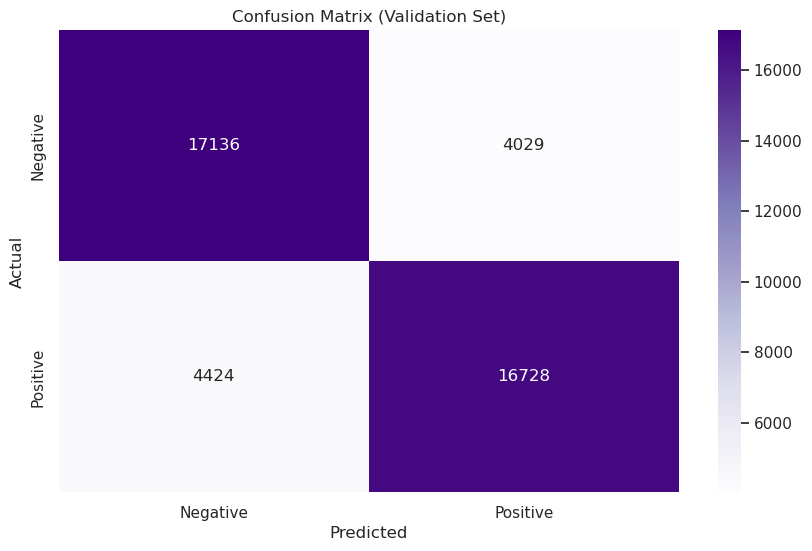

In [440]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Create a heatmap
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

**2. ROC Curve (Receiver Operating Characteristic)**

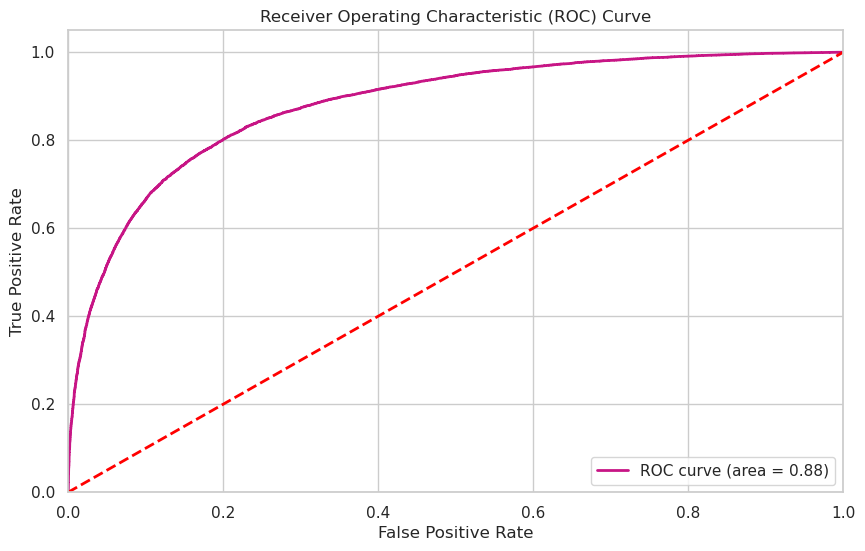

In [441]:
# Calculate True Positive Rate (TPR) & False Positive Rate (FPR)
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)

# Calculate AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot for ROC Curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color="#C71585", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

**3. Learning Curve**

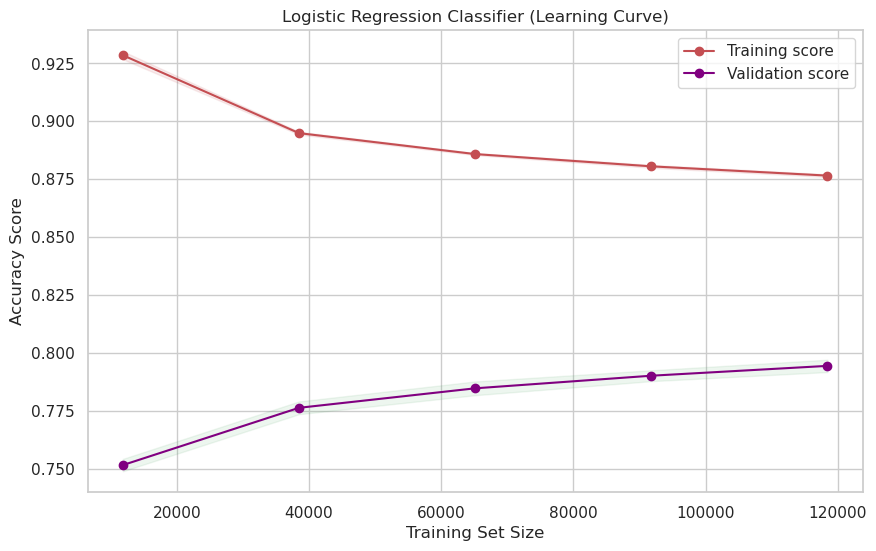

In [443]:
# Calculate learning curve
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, n_jobs=-1, cv=5, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

# Calculate mean and dispersion
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Set plot
plt.figure(figsize=(10,6))
# Box-like grid
plt.grid(True)

# Plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="purple", label="Validation score")

# Plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")

plt.title("Logistic Regression Classifier (Learning Curve)")
plt.legend(loc="best")

plt.show()

Make predictions using test set

In [434]:
# Make predictions using test set
test_pred = model.predict(X_test)

Save predictions into a csv file

In [435]:
submission_df = pd.DataFrame({"ID": df_test["ID"], "Label": test_pred})
submission_df.to_csv("submission.csv", index=False)